# Deep, Wide and Cross Networks

Even though deep learning has attained tremendous success on data domains such as images, audio and texts.
GDBT still rule the domain of tabular data.

In this note we will discuss 3 Neural Network Architectures for tabular deep learning
1. Deep Network: a multi-layer feed-forward network, where the categorical features are one-hot encoded.
2. Wide and Deep Model ([Wide & Deep Learning: Better Together with TensorFlow](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)):
    * The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.
    * A sparse representation of the input features is used in the wide part of the model and the dense representation of the input features for the deep part of the model.
3. Deep and Cross Model ([Deep & Cross Network for Ad Click Predictions](https://arxiv.org/pdf/1708.05123.pdf)):
    * The deep part of this model is the same. 
    * The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import joblib


# Data

In [2]:
data = pd.read_csv('../input/song-popularity-prediction/train.csv')
print(data.shape)
data.head()

(40000, 15)


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [3]:
test = pd.read_csv('../input/song-popularity-prediction/test.csv')
X_test = test.drop(['id'], axis=1)

In [4]:
X = data.drop(['id', 'song_popularity'], axis=1)
y = data['song_popularity']

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Model

In [6]:
class TabularNetworkConfig():
    def __init__(
        self, 
        target_feature_name, 
        target_feature_labels, 
        numeric_feature_names, 
        categorical_features_with_vocabulary,
        num_outputs,
        out_activation,
        hidden_units, 
        dropout_rate,
        embedding_dim,
    ):
        self.TARGET_FEATURE_NAME = target_feature_name
        self.TARGET_FEATURE_LABELS = target_feature_labels
        self.NUMERIC_FEATURE_NAMES = numeric_feature_names
        self.CATEGORICAL_FEATURES_WITH_VOCABULARY = categorical_features_with_vocabulary
        self.CATEGORICAL_FEATURE_NAMES = list(self.CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
        self.FEATURE_NAMES = self.NUMERIC_FEATURE_NAMES + self.CATEGORICAL_FEATURE_NAMES
        self.NUM_OUT = num_outputs
        self.OUT_ACTIVATION = out_activation
        self.HIDDEN_UNITS = hidden_units
        self.DROPOUT_RATE = dropout_rate
        self.EMBEDDING_DIM = embedding_dim

class BaseTabularNetwork():
    @staticmethod
    def get_inputs(config):
        return {
        feature_name: L.Input(
            name=feature_name,
            shape=(),
            dtype=(tf.float32 if feature_name in config.NUMERIC_FEATURE_NAMES else tf.string),
        )
        for feature_name in config.FEATURE_NAMES
    }
    
    @staticmethod
    def encode_inputs(inputs, config, use_embeddings=False, prefix=''):
        encoded_features = []
        for feature_name in inputs:
            if feature_name in config.CATEGORICAL_FEATURE_NAMES:
                vocabulary = config.CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
                lookup = L.StringLookup(
                    vocabulary=vocabulary,
                    mask_token=None,
                    num_oov_indices=0,
                    output_mode="int" if use_embeddings else "binary",
                    name=f"{prefix}{feature_name}_lookup"
                )
                if use_embeddings:
                    encoded_feature = lookup(inputs[feature_name])
                    embedding = L.Embedding(
                        input_dim=len(vocabulary), output_dim=config.EMBEDDING_DIM,
                        name=f"{prefix}{feature_name}_embeddings"
                    )
                    encoded_feature = embedding(encoded_feature)
                else:
                    encoded_feature = lookup(L.Reshape((1, ), name=f"{prefix}{feature_name}_reshape")(inputs[feature_name]))
            else:
                encoded_feature = L.Reshape((1, ), name=f"{prefix}{feature_name}_reshape")(inputs[feature_name])
            encoded_features.append(encoded_feature)

        all_features = L.Concatenate(name=f"{prefix}inputs_concatenate")(encoded_features)
        return all_features

In [7]:
class DeepTabularNetwork(BaseTabularNetwork):
    @classmethod
    def from_config(cls, name, config):
        inputs = cls.get_inputs(config)
        features = cls.encode_inputs(inputs, config)
        
        for i, units in enumerate(config.HIDDEN_UNITS):
            features = L.Dense(units, name=f"block_{i+1}_dense")(features)
            features = L.BatchNormalization(name=f"block_{i+1}_b_norm")(features)
            features = L.ReLU(name=f"block_{i+1}_relu")(features)
            features = L.Dropout(config.DROPOUT_RATE, name=f"block_{i+1}_dropout")(features)

        outputs = L.Dense(units=config.NUM_OUT, activation=config.OUT_ACTIVATION, name="outputs")(features)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return model

class WideAndDeepTabularNetwork(BaseTabularNetwork):
    @classmethod
    def from_config(cls, name, config):
        inputs = cls.get_inputs(config)
        wide = cls.encode_inputs(inputs, config, prefix="wide_")
        deep = cls.encode_inputs(inputs, config, use_embeddings=True, prefix="deep_")
        
        for i, units in enumerate(config.HIDDEN_UNITS):
            deep = L.Dense(units, name=f"block_{i+1}_dense")(deep)
            deep = L.BatchNormalization(name=f"block_{i+1}_b_norm")(deep)
            deep = L.ReLU(name=f"block_{i+1}_relu")(deep)
            deep = L.Dropout(config.DROPOUT_RATE, name=f"block_{i+1}_dropout")(deep)

        merged = L.Concatenate(name="network_concatenate")([wide, deep])
        outputs = L.Dense(units=config.NUM_OUT, activation=config.OUT_ACTIVATION, name="outputs")(merged)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return model
    
class DeepAndCrossTabularNetwork(BaseTabularNetwork):
    @classmethod
    def from_config(cls, name, config):
        inputs = cls.get_inputs(config)
        x0 = cls.encode_inputs(inputs, config, use_embeddings=True)
        
        cross = x0
        for i in range(len(config.HIDDEN_UNITS)):
            units = cross.shape[-1]
            x = L.Dense(units, name=f"cross_{i+1}_dense")(cross)
            cross = L.Lambda(lambda x: x[0] * x[1] + x[2], name=f"cross_{i+1}")((x0, x, cross))
        cross = L.BatchNormalization(name="cross_b_norm")(cross)
        
        deep = x0
        for i, units in enumerate(config.HIDDEN_UNITS):
            deep = L.Dense(units, name=f"block_{i+1}_dense")(deep)
            deep = L.BatchNormalization(name=f"block_{i+1}_b_norm")(deep)
            deep = L.ReLU(name=f"block_{i+1}_relu")(deep)
            deep = L.Dropout(config.DROPOUT_RATE, name=f"block_{i+1}_dropout")(deep)
        

        merged = L.Concatenate(name="network_concatenate")([cross, deep])
        outputs = L.Dense(units=config.NUM_OUT, activation=config.OUT_ACTIVATION, name="outputs")(merged)
        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        return model    

In [8]:
model_config = TabularNetworkConfig(
    target_feature_name="song_popularity", 
    target_feature_labels=["0", "1"], 
    numeric_feature_names=[
        'song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
        'speechiness', 'tempo', 'audio_valence'
    ], 
    categorical_features_with_vocabulary={
        'key': list(map(str, range(12))),
        'audio_mode': ["0", "1"],
        'time_signature': ["2", "3", "4", "5"]   
    },
    num_outputs=1,
    out_activation="sigmoid",
    hidden_units=[64, 64],
    dropout_rate=0.3,
    embedding_dim=32
)

MAX_EPOCHS  = 250

get_callbacks = lambda : [
    keras.callbacks.EarlyStopping(min_delta=1e-4, patience=10, verbose=1, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
]


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

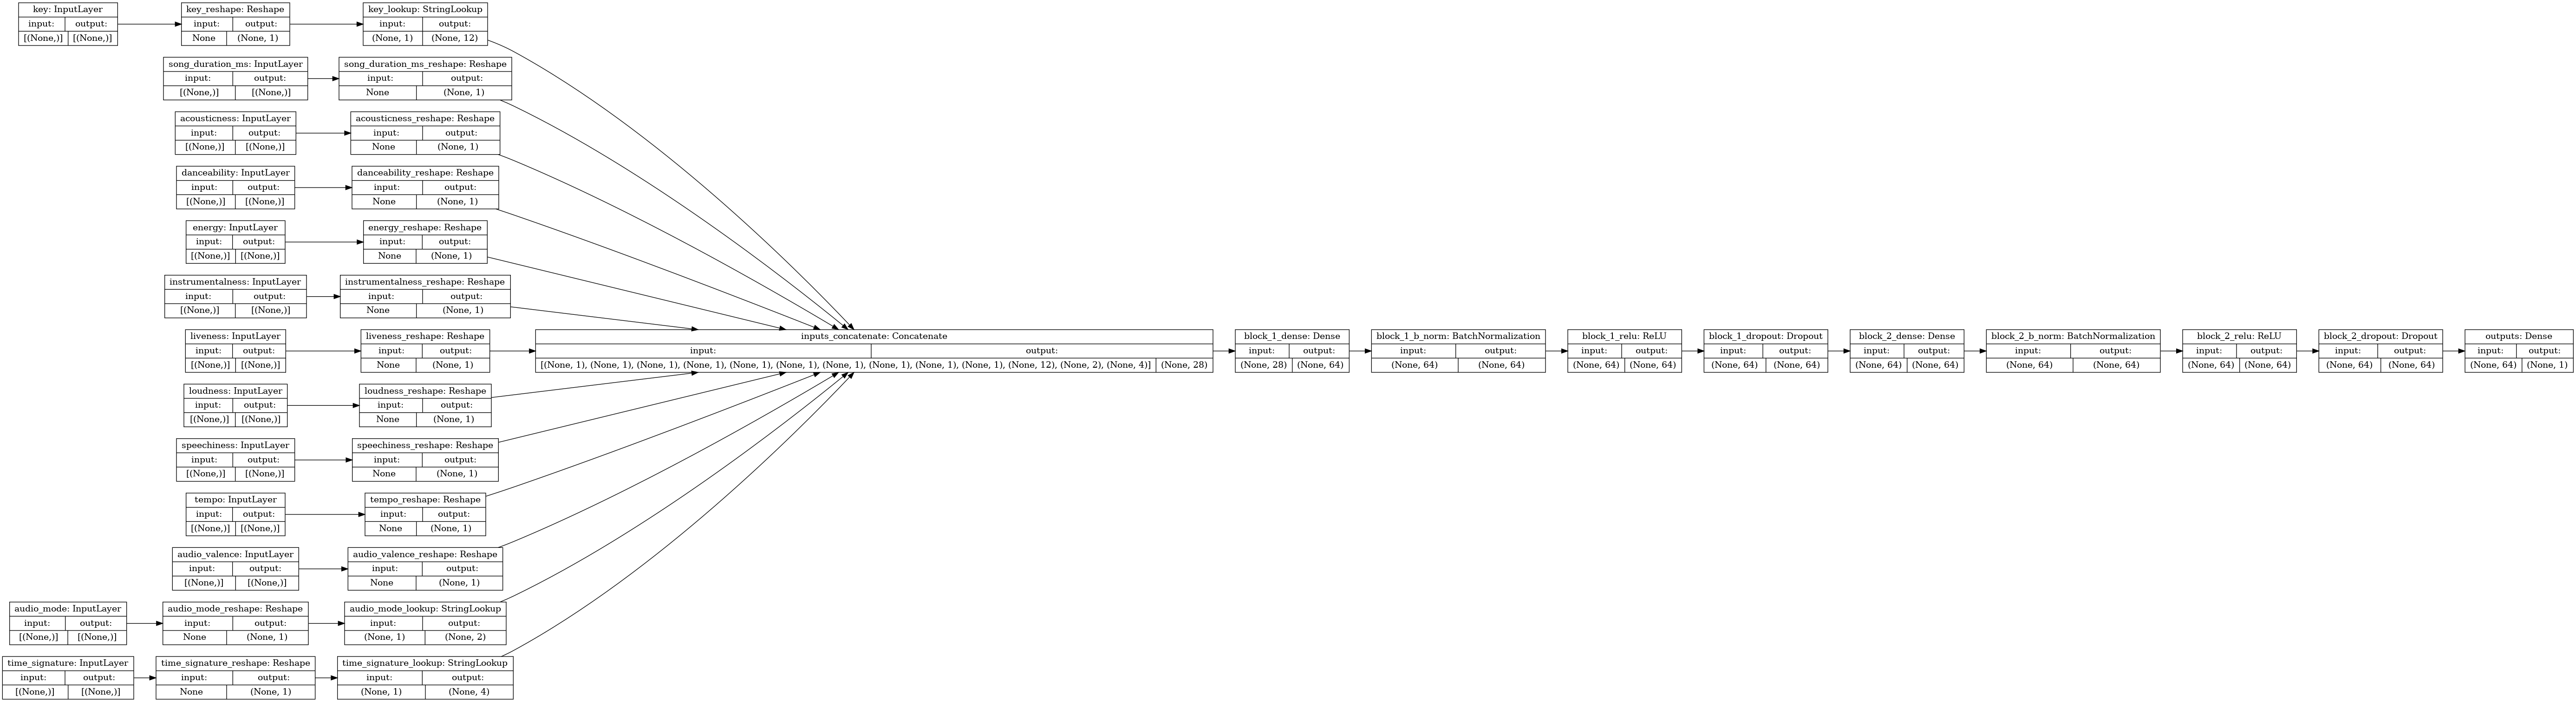

In [9]:
keras.utils.plot_model(
    DeepTabularNetwork.from_config("deep_network", model_config),
    show_shapes=True, rankdir="LR", to_file="deep_model.png"
)

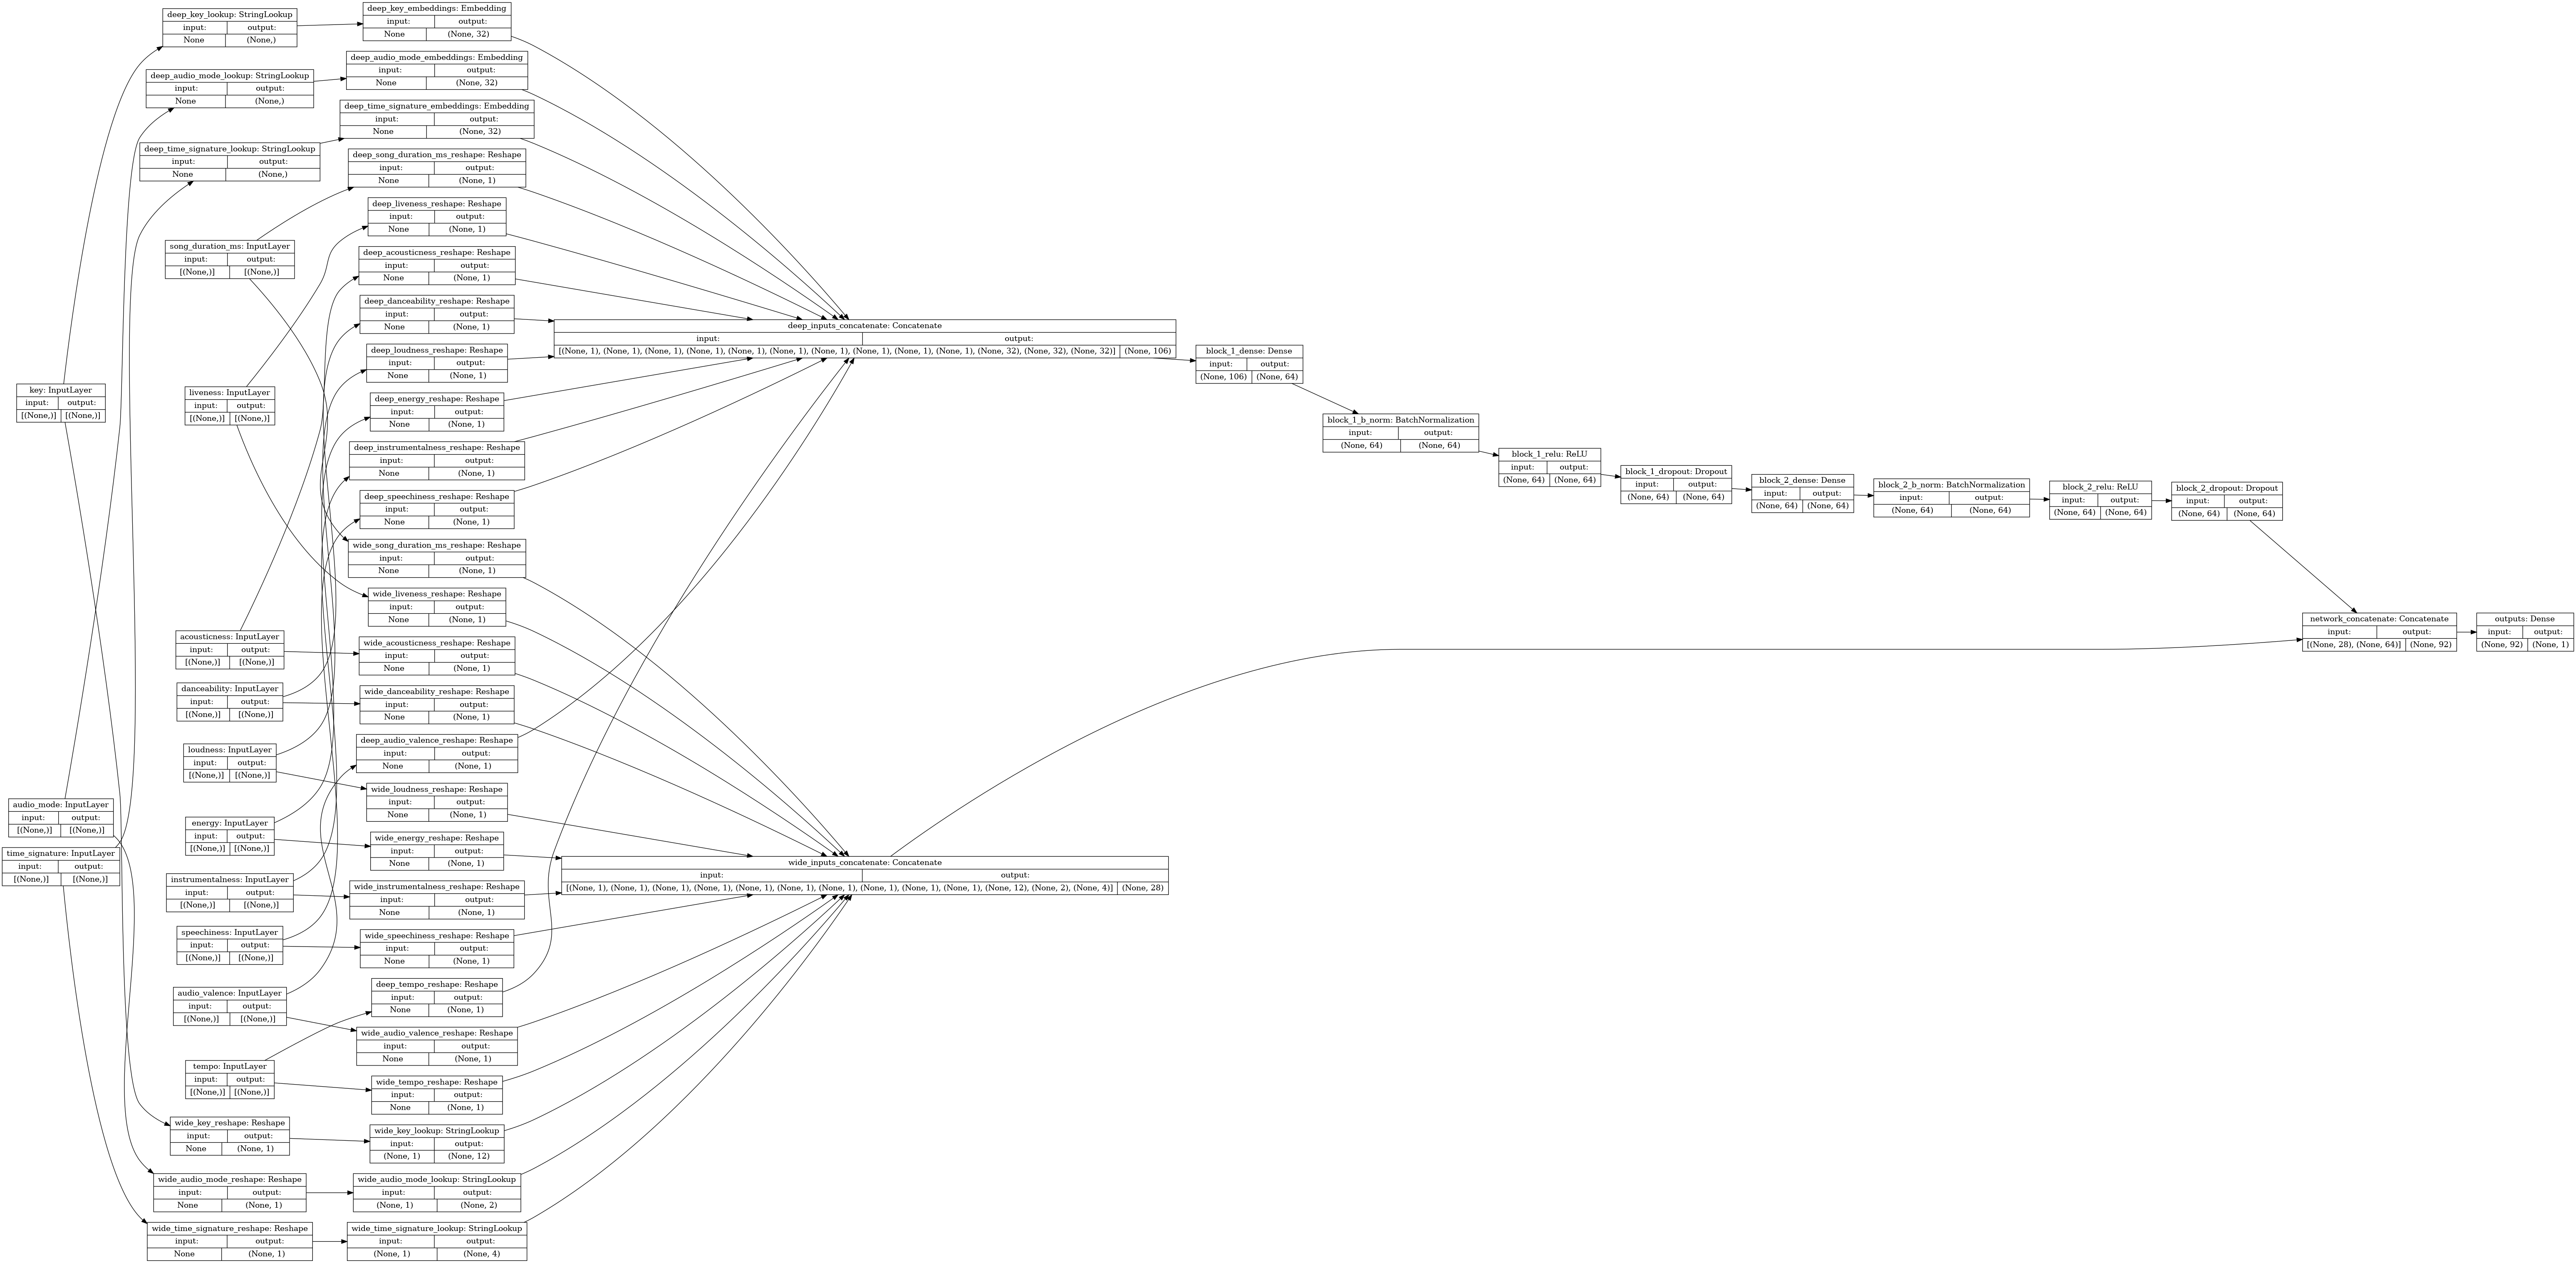

In [10]:
keras.utils.plot_model(
    WideAndDeepTabularNetwork.from_config("wide_deep_network", model_config), 
    show_shapes=True, rankdir="LR", to_file="wide_deep_model.png"
)

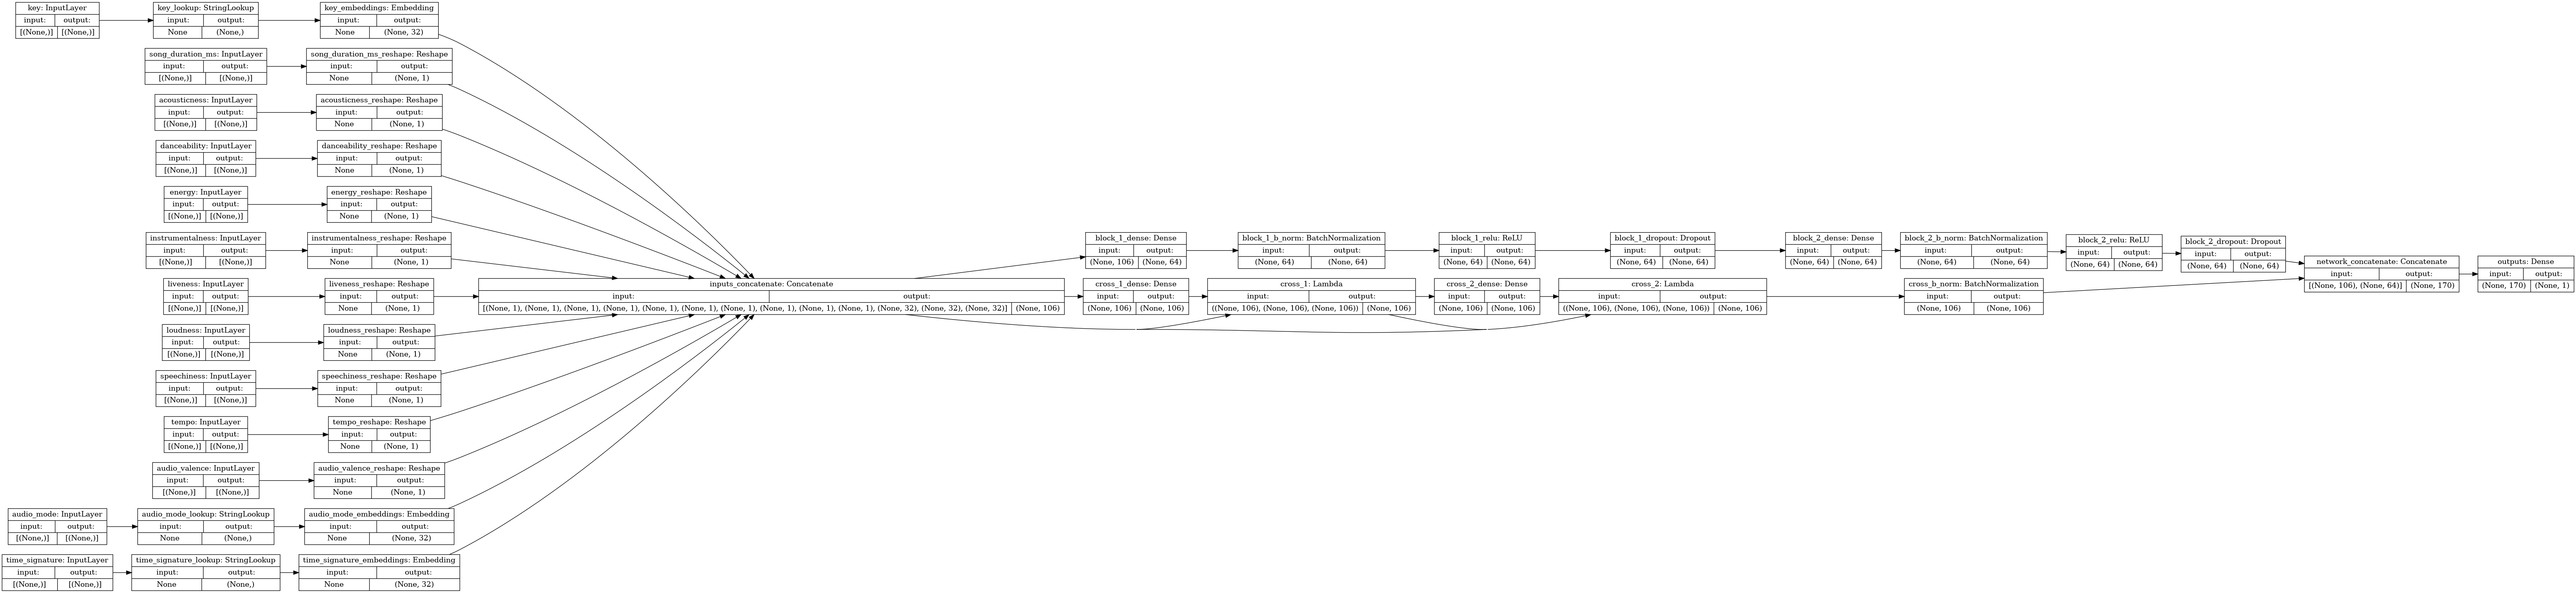

In [11]:
keras.utils.plot_model(
    DeepAndCrossTabularNetwork.from_config("deep_cross_model", model_config), 
    show_shapes=True, rankdir="LR", to_file="deep_cross_model.png"
)

# Training

In [12]:
preds_deep = []
preds_wide_deep = []
preds_deep_cross = []

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    mean_imputer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ]).fit(X_train[model_config.NUMERIC_FEATURE_NAMES])
    mode_imputer = SimpleImputer(strategy='most_frequent').fit(X_train[model_config.CATEGORICAL_FEATURE_NAMES])
    
    X_train = pd.concat([
        pd.DataFrame(
            mean_imputer.transform(X_train[model_config.NUMERIC_FEATURE_NAMES]), 
            columns=model_config.NUMERIC_FEATURE_NAMES
        ),
        pd.DataFrame(
            mode_imputer.transform(X_train[model_config.CATEGORICAL_FEATURE_NAMES]).astype(float).astype(int), 
            columns=model_config.CATEGORICAL_FEATURE_NAMES
        ).astype(str),
    ], axis=1)
    X_valid = pd.concat([
        pd.DataFrame(
            mean_imputer.transform(X_valid[model_config.NUMERIC_FEATURE_NAMES]), 
            columns=model_config.NUMERIC_FEATURE_NAMES
        ),
        pd.DataFrame(
            mode_imputer.transform(X_valid[model_config.CATEGORICAL_FEATURE_NAMES]).astype(float).astype(int), 
            columns=model_config.CATEGORICAL_FEATURE_NAMES
        ).astype(str),
    ], axis=1)
    X_test_ = pd.concat([
        pd.DataFrame(
            mean_imputer.transform(X_test[model_config.NUMERIC_FEATURE_NAMES]), 
            columns=model_config.NUMERIC_FEATURE_NAMES
        ),
        pd.DataFrame(
            mode_imputer.transform(X_test[model_config.CATEGORICAL_FEATURE_NAMES]).astype(float).astype(int), 
            columns=model_config.CATEGORICAL_FEATURE_NAMES
        ).astype(str),
    ], axis=1)
        
    data_train = tf.data.Dataset.from_tensor_slices((
    {col: X_train[col].values.tolist() for col in model_config.FEATURE_NAMES}, 
        y_train.values.tolist()
    )).batch(1024)
    data_valid = tf.data.Dataset.from_tensor_slices((
        {col: X_valid[col].values.tolist() for col in model_config.FEATURE_NAMES}, 
        y_valid.values.tolist()
    )).batch(1024)
    data_test = tf.data.Dataset.from_tensor_slices((
        {col: X_test_[col].values.tolist() for col in model_config.FEATURE_NAMES}
    )).batch(1024)
    
    deep_model = DeepTabularNetwork.from_config("deep_network", model_config)
    deep_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    deep_model.fit(data_train, validation_data=data_valid, callbacks=get_callbacks(), epochs=MAX_EPOCHS)  
    preds_deep.append(deep_model.predict(data_test))
    
    wide_deep_model = WideAndDeepTabularNetwork.from_config("wide_deep_network", model_config)
    wide_deep_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    wide_deep_model.fit(data_train, validation_data=data_valid, callbacks=get_callbacks(), epochs=MAX_EPOCHS)
    preds_wide_deep.append(wide_deep_model.predict(data_test))
    
    deep_cross_model = DeepAndCrossTabularNetwork.from_config("deep_cross_model", model_config)
    deep_cross_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    deep_cross_model.fit(data_train, validation_data=data_valid, callbacks=get_callbacks(), epochs=MAX_EPOCHS) 
    preds_deep_cross.append(deep_cross_model.predict(data_test))

Epoch 1/250


2022-01-22 05:02:08.325651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


36/36 [==============================] - 3s 39ms/step - loss: 0.7650 - accuracy: 0.5138 - val_loss: 0.6642 - val_accuracy: 0.6300
Epoch 2/250
36/36 [==============================] - 1s 22ms/step - loss: 0.7054 - accuracy: 0.5927 - val_loss: 0.6615 - val_accuracy: 0.6332
Epoch 3/250
36/36 [==============================] - 1s 21ms/step - loss: 0.6947 - accuracy: 0.5987 - val_loss: 0.6569 - val_accuracy: 0.6355
Epoch 4/250
36/36 [==============================] - 1s 23ms/step - loss: 0.6864 - accuracy: 0.5986 - val_loss: 0.6536 - val_accuracy: 0.6360
Epoch 5/250
36/36 [==============================] - 1s 21ms/step - loss: 0.6815 - accuracy: 0.6058 - val_loss: 0.6538 - val_accuracy: 0.6365
Epoch 6/250
36/36 [==============================] - 1s 22ms/step - loss: 0.6764 - accuracy: 0.6102 - val_loss: 0.6525 - val_accuracy: 0.6367
Epoch 7/250
36/36 [==============================] - 1s 23ms/step - loss: 0.6709 - accuracy: 0.6152 - val_loss: 0.6515 - val_accuracy: 0.6367
Epoch 8/250
36/36 

# Submissions

In [13]:
submissions = pd.read_csv('../input/song-popularity-prediction/sample_submission.csv')
submissions['song_popularity'] = np.array(preds_deep).mean(axis=0)
submissions.to_csv('preds_deep.csv', index=False)

submissions['song_popularity'] = np.array(preds_wide_deep).mean(axis=0)
submissions.to_csv('preds_wide_deep.csv', index=False)

submissions['song_popularity'] = np.array(preds_deep_cross).mean(axis=0)
submissions.to_csv('preds_deep_cross.csv', index=False)